In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from scipy.stats import beta as beta_dist

PROJECT_ROOT = Path.cwd().parent 
DATA_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"


**In this ipynb we establish robust Bayesian priors for player performance using historical 2023 Wimbledon data**

Objectives: 
- Data Cleaning: Reconstruct missing FirstServeIn statistics using point-level ServeNumber logic.

- Prior Elicitation: Extract player-specific beliefs (Serve %, Ace Rate) from 2023 matches.

- Variance Inflation: Weaken historical priors to allow the 2024 target match data to drive the posterior updates.

## Data exploration

In [12]:
matches_2023 = pd.read_csv(DATA_DIR / '2023-wimbledon-matches.csv')
points_2023 = pd.read_csv(DATA_DIR / '2023-wimbledon-points.csv')

matches_2024 = pd.read_csv(DATA_DIR / '2024-wimbledon-matches.csv')
points_2024 = pd.read_csv(DATA_DIR / '2024-wimbledon-points.csv')

print(f"2023 Matches: {len(matches_2023)} rows")
print(f"2023 Points: {len(points_2023)} rows")
print(f"2024 Matches: {len(matches_2024)} rows")
print(f"2024 Points: {len(points_2024)} rows")

# Check critical columns in points data
critical_cols = ['match_id', 'PointNumber', 'PointServer', 'PointWinner', 
                 'ServeNumber', 'P1FirstSrvIn', 'P2FirstSrvIn', 'P1Ace', 'P2Ace']

print("\nMissing values in critical columns (2024):")
missing_2024 = points_2024[critical_cols].isnull().sum()
print(missing_2024[missing_2024 > 0])

print("\nMissing values in critical columns (2023):")
missing_2023 = points_2023[critical_cols].isnull().sum()
print(missing_2023[missing_2023 > 0])

# Assess ServeNumber column
print("\n ServeNumber distribution (2024):")
print(points_2024['ServeNumber'].value_counts().sort_index())

2023 Matches: 254 rows
2023 Points: 48676 rows
2024 Matches: 252 rows
2024 Points: 48155 rows

Missing values in critical columns (2024):
P1FirstSrvIn    48155
P2FirstSrvIn    48155
dtype: int64

Missing values in critical columns (2023):
P1FirstSrvIn    48676
P2FirstSrvIn    48676
dtype: int64

 ServeNumber distribution (2024):
ServeNumber
0     2386
1    30022
2    15747
Name: count, dtype: int64


## Data Cleaning: Reconstructing Serve Statistics
The raw point-by-point data contains missing values for FirstServeIn. We reconstruct this using the ServeNumber column which is fully populated.

**Logic:**

- ServeNumber = 1: The point ended on the first serve. Therefore, the first serve was IN. (Attempts +1, Made +1).

- ServeNumber = 2: The point required a second serve. Therefore, the first serve was OUT. (Attempts +1, Made +0).

This reconstruction creates the "Silver" layer of our data, which will be saved for all downstream analysis.

In [13]:
# --- helper functions ---

def calculate_first_serve_stats(points_df):
    """
    Calculate cumulative first serve statistics from ServeNumber column.
    
    CORRECTED LOGIC (per-point):
    - ServeNumber=1: First serve IN (increment attempts AND in)
    - ServeNumber=2: First serve OUT (increment attempts only)
    - ServeNumber=0: Metadata (skip)
    
    Args:
        points_df: DataFrame with match-point data
    
    Returns:
        DataFrame with P1FirstSrvIn, P1FirstSrvTotal, P2FirstSrvIn, P2FirstSrvTotal
    """
    df = points_df.copy()
    
    # initialize counters
    df['P1FirstSrvIn'] = 0
    df['P2FirstSrvIn'] = 0
    df['P1FirstSrvTotal'] = 0
    df['P2FirstSrvTotal'] = 0
    
    # iterate by match to ensure counters reset
    # using a vectorized approach where possible would be faster, but row iteration is safer for cumulative running states
    for match_id in df['match_id'].unique():
        mask = df['match_id'] == match_id
        match_points = df[mask].copy()
        
        p1_in, p1_total = 0, 0
        p2_in, p2_total = 0, 0
        
        # storage for this match
        p1_in_vals, p1_tot_vals = [], []
        p2_in_vals, p2_tot_vals = [], []
        
        for _, row in match_points.iterrows():
            server = row['PointServer']
            serve_num = row['ServeNumber']
            
            if serve_num == 1:
                # first serve went in
                if server == 1:
                    p1_total += 1
                    p1_in += 1
                elif server == 2:
                    p2_total += 1
                    p2_in += 1
            elif serve_num == 2:
                # second serve implies first serve missed
                if server == 1:
                    p1_total += 1
                elif server == 2:
                    p2_total += 1
            
            p1_in_vals.append(p1_in)
            p1_tot_vals.append(p1_total)
            p2_in_vals.append(p2_in)
            p2_tot_vals.append(p2_total)
            
        # assign back
        df.loc[mask, 'P1FirstSrvIn'] = p1_in_vals
        df.loc[mask, 'P1FirstSrvTotal'] = p1_tot_vals
        df.loc[mask, 'P2FirstSrvIn'] = p2_in_vals
        df.loc[mask, 'P2FirstSrvTotal'] = p2_tot_vals
        
    return df

def get_beta_params(successes, total, inflation_factor=10):
    """
    Compute beta parameters (alpha, beta) using method of moments.
    applies variance inflation (dividing n by factor) to weaken the prior.
    """
    if total == 0:
        return {'alpha': 1, 'beta': 1, 'mean': 0.5}
        
    # inflate variance to allow new data to speak
    adj_success = successes / inflation_factor
    adj_total = total / inflation_factor
    adj_fail = adj_total - adj_success
    
    # add minimal smoothing
    alpha = adj_success + 1
    beta = adj_fail + 1
    
    return {
        'alpha': alpha,
        'beta': beta,
        'mean': alpha / (alpha + beta)
    }

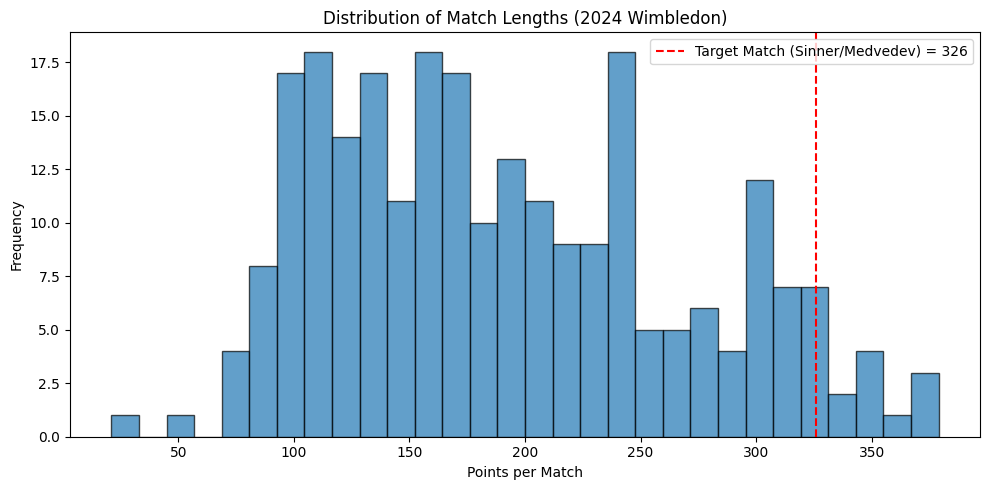

In [14]:
# reconstructing missing serve statistics
points_2023_corr = calculate_first_serve_stats(points_2023)
points_2024_corr = calculate_first_serve_stats(points_2024)

# Visualization: Match Length Distribution
match_lengths = points_2024_corr.groupby('match_id').size()

plt.figure(figsize=(10, 5))
plt.hist(match_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(326, color='red', linestyle='--', label='Target Match (Sinner/Medvedev) = 326')
plt.title('Distribution of Match Lengths (2024 Wimbledon)')
plt.xlabel('Points per Match')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# save files
points_2023_corr.to_csv(PROCESSED_DIR / '2023-wimbledon-points-corrected.csv', index=False)
points_2024_corr.to_csv(PROCESSED_DIR / '2024-wimbledon-points-corrected.csv', index=False)



## Statistical Methodology: Beta Priors

We model serve probabilities using the Beta distribution, which is the conjugate prior for the Binomial likelihood.

**Key Formula**

For a Beta($\alpha, \beta$) distribution:

- Mean: $\mu = \frac{\alpha}{\alpha + \beta}

- Variance: $\sigma^2 = \frac{\alpha\beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$

**Variance Inflation Strategy**

We apply a variance inflation factor of 10 to the historical 2023 counts.

- Why? Tennis players evolve. A hard prior based on hundreds of 2023 points would overwhelm the signal from the specific 2024 match we are analyzing.

- Method: We divide the observed counts ($n$) by 10 before adding the smoothing constants. This widens the distribution (increases uncertainty) while keeping the mean centered on the historical average.


In [15]:
def get_beta_params(successes, total, inflation_factor=10):
    """
    Compute Beta parameters (alpha, beta) using variance inflation.
    
    Args:
        successes (int): Number of successful events (e.g., Serve In)
        total (int): Total number of attempts
        inflation_factor (int): Divisor for counts to increase prior variance
    """
    if total == 0:
        return {'alpha': 1, 'beta': 1, 'mean': 0.5}
        
    # Apply variance inflation
    adj_success = successes / inflation_factor
    adj_total = total / inflation_factor
    adj_fail = adj_total - adj_success
    
    # Add Laplace smoothing (+1) to prevent zero-mass tails
    alpha = adj_success + 1
    beta = adj_fail + 1
    
    return {
        'alpha': alpha,
        'beta': beta,
        'mean': alpha / (alpha + beta)
    }

# Define Players
target_p1 = "Jannik Sinner"
target_p2 = "Daniil Medvedev"

# Filter Match IDs
p1_matches = matches_2023[
    (matches_2023['player1'] == target_p1) | 
    (matches_2023['player2'] == target_p1)
]['match_id'].unique()

p2_matches = matches_2023[
    (matches_2023['player1'] == target_p2) | 
    (matches_2023['player2'] == target_p2)
]['match_id'].unique()

priors = {}

# Extraction Loop
for player, match_ids in [(target_p1, p1_matches), (target_p2, p2_matches)]:
    
    total_srv_in = 0
    total_srv_att = 0
    total_aces = 0
    total_srv_points = 0
    
    for mid in match_ids:
        m_pts = points_2023_corr[points_2023_corr['match_id'] == mid]
        m_meta = matches_2023[matches_2023['match_id'] == mid].iloc[0]
        
        if m_pts.empty: continue
            
        if m_meta['player1'] == player:
            last_pt = m_pts.iloc[-1]
            total_srv_in += last_pt['P1FirstSrvIn']
            total_srv_att += last_pt['P1FirstSrvTotal']
            total_aces += m_pts[m_pts['PointServer'] == 1]['P1Ace'].sum()
            total_srv_points += len(m_pts[m_pts['PointServer'] == 1])
            
        elif m_meta['player2'] == player:
            last_pt = m_pts.iloc[-1]
            total_srv_in += last_pt['P2FirstSrvIn']
            total_srv_att += last_pt['P2FirstSrvTotal']
            total_aces += m_pts[m_pts['PointServer'] == 2]['P2Ace'].sum()
            total_srv_points += len(m_pts[m_pts['PointServer'] == 2])

    clean_name = player.lower().replace(" ", "_")
    
    # Calculate Observed Means (for final validation)
    obs_serve_pct = total_srv_in / total_srv_att if total_srv_att > 0 else 0
    obs_ace_rate = total_aces / total_srv_points if total_srv_points > 0 else 0
    
    # Compute Beta Parameters (Inflated)
    priors[clean_name] = {
        'serve_pct': get_beta_params(total_srv_in, total_srv_att),
        'ace_rate': get_beta_params(total_aces, total_srv_points),
        'stats': {
            'matches': len(match_ids),
            'points_served': total_srv_points,
            'obs_serve_pct': obs_serve_pct,
            'obs_ace_rate': obs_ace_rate
        }
    }
    
    # Output Basic Stats
    print(f"\n--- {player} (2023 Historical) ---")
    print(f"Matches: {len(match_ids)} | Points Served: {total_srv_points}")
    print(f"Observed Serve %: {obs_serve_pct:.3f}")
    print(f"Prior Mean (Inflated): {priors[clean_name]['serve_pct']['mean']:.3f}")


--- Jannik Sinner (2023 Historical) ---
Matches: 6 | Points Served: 505
Observed Serve %: 0.582
Prior Mean (Inflated): 0.578

--- Daniil Medvedev (2023 Historical) ---
Matches: 6 | Points Served: 563
Observed Serve %: 0.702
Prior Mean (Inflated): 0.695


## Prior  Visualization

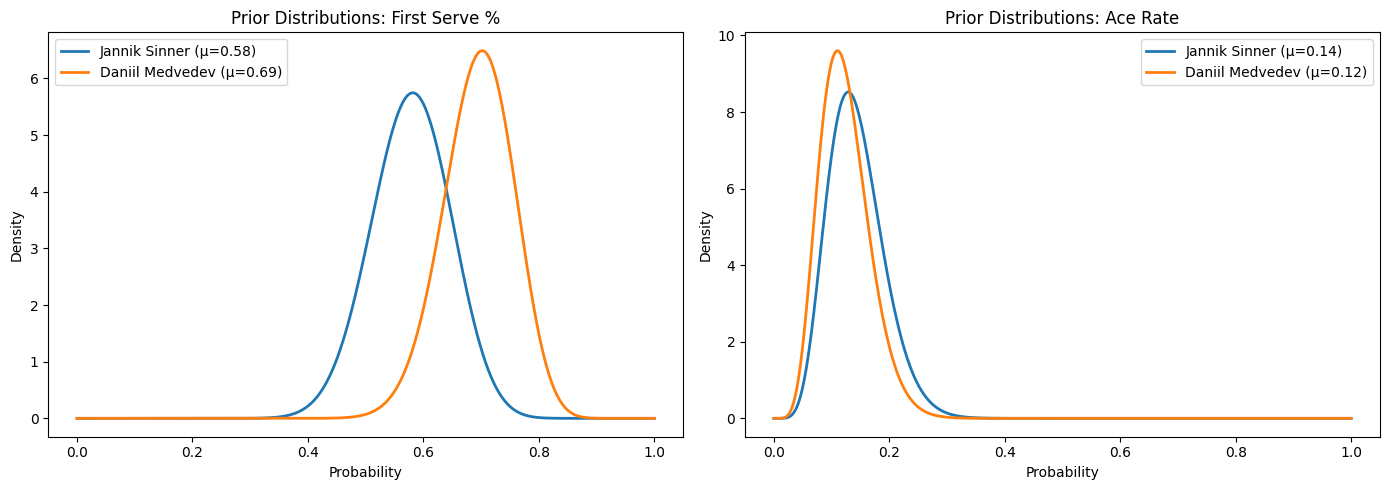

Priors dictionary saved to c:\Users\tanbe\tennis_prob\data\processed\priors_2023.pkl


In [16]:
x = np.linspace(0, 1, 1000)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot First Serve %
ax = axes[0]
for player in [target_p1, target_p2]:
    key = player.lower().replace(" ", "_")
    params = priors[key]['serve_pct']
    y = beta_dist.pdf(x, params['alpha'], params['beta'])
    ax.plot(x, y, label=f"{player} (μ={params['mean']:.2f})", linewidth=2)

ax.set_title('Prior Distributions: First Serve %')
ax.set_xlabel('Probability')
ax.set_ylabel('Density')
ax.legend()

# Plot Ace Rate
ax = axes[1]
for player in [target_p1, target_p2]:
    key = player.lower().replace(" ", "_")
    params = priors[key]['ace_rate']
    y = beta_dist.pdf(x, params['alpha'], params['beta'])
    ax.plot(x, y, label=f"{player} (μ={params['mean']:.2f})", linewidth=2)

ax.set_title('Prior Distributions: Ace Rate')
ax.set_xlabel('Probability')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()

# Save Priors for downstream modeling
output_path = PROCESSED_DIR / 'priors_2023.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(priors, f)

print(f"Priors dictionary saved to {output_path}")

In [17]:
# Detailed Statistical Validation
print("Prior Validation (comparing to observed 2023 data):")
print("\n" + "=" * 70)

for player in [target_p1, target_p2]:
    key = player.lower().replace(" ", "_")
    stats = priors[key]['stats']
    prior_srv = priors[key]['serve_pct']
    prior_ace = priors[key]['ace_rate']
    
    print(f"\n{player}:")
    
    print(f"  First Serve %:")
    print(f"    Observed (2023): {stats['obs_serve_pct']:.3f}")
    print(f"    Prior Mean:      {prior_srv['mean']:.3f}")
    print(f"    Difference:      {abs(stats['obs_serve_pct'] - prior_srv['mean']):.3f}")

    print(f"\n  Ace Rate:")
    print(f"    Observed (2023): {stats['obs_ace_rate']:.3f}")
    print(f"    Prior Mean:      {prior_ace['mean']:.3f}")
    print(f"    Difference:      {abs(stats['obs_ace_rate'] - prior_ace['mean']):.3f}")

#Note: Priors should be CLOSE to observed values (within ~0.01-0.02)
#Large differences indicate potential data quality issues.

Prior Validation (comparing to observed 2023 data):


Jannik Sinner:
  First Serve %:
    Observed (2023): 0.582
    Prior Mean:      0.578
    Difference:      0.003

  Ace Rate:
    Observed (2023): 0.129
    Prior Mean:      0.143
    Difference:      0.014

Daniil Medvedev:
  First Serve %:
    Observed (2023): 0.702
    Prior Mean:      0.695
    Difference:      0.007

  Ace Rate:
    Observed (2023): 0.110
    Prior Mean:      0.123
    Difference:      0.013
